In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from feature_engine import imputation
from feature_engine import encoding

# pipeline utility
from sklearn.pipeline import Pipeline

# preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer

# metrics to evaluate models
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error

# feature selection
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

# estimators
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge

In [2]:
house_data = pd.read_csv('../data/train.csv', index_col='Id')
X = house_data.drop(labels='SalePrice', axis=1)
Y = house_data['SalePrice']
X.shape, Y.shape

((1460, 79), (1460,))

In [3]:
clean_pipeline = Pipeline(steps=[('most_miss_cat', imputation.CategoricalImputer(variables=['Alley',
                                                                                            'FireplaceQu',
                                                                                            'PoolQC',
                                                                                            'Fence',
                                                                                            'MiscFeature'])),
                                 ('least_miss_cat', imputation.RandomSampleImputer(random_state='LotArea',
                                                                                   seed='observation',
                                                                                   variables=['GarageCond',
                                                                                              'GarageType',
                                                                                              'GarageFinish',
                                                                                              'GarageQual',
                                                                                              'BsmtExposure',
                                                                                              'BsmtFinType2',
                                                                                              'BsmtCond',
                                                                                              'BsmtQual',
                                                                                              'BsmtFinType1',
                                                                                              'MasVnrType',
                                                                                              'Electrical'])),
                                 ('least_miss_num', imputation.RandomSampleImputer(random_state='LotArea',
                                                                                   seed='observation',
                                                                                   variables=['LotFrontage',
                                                                                              'GarageYrBlt',
                                                                                              'MasVnrArea'])),
                                 ('encode', encoding.OrdinalEncoder(
                                     variables=X.select_dtypes(include=object).columns.to_list())),
                                 ('scaling', RobustScaler()),
                                 ('transform', QuantileTransformer(output_distribution='normal')),
                                 ('scale_to_range', MinMaxScaler())],
                          )

clean_pipeline.get_params()

{'memory': None,
 'steps': [('most_miss_cat',
   CategoricalImputer(variables=['Alley', 'FireplaceQu', 'PoolQC', 'Fence',
                                 'MiscFeature'])),
  ('least_miss_cat',
   RandomSampleImputer(random_state='LotArea', seed='observation',
                       variables=['GarageCond', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'BsmtExposure', 'BsmtFinType2',
                                  'BsmtCond', 'BsmtQual', 'BsmtFinType1',
                                  'MasVnrType', 'Electrical'])),
  ('least_miss_num',
   RandomSampleImputer(random_state='LotArea', seed='observation',
                       variables=['LotFrontage', 'GarageYrBlt', 'MasVnrArea'])),
  ('encode',
   OrdinalEncoder(variables=['MSZoning', 'Street', 'Alley', 'LotShape',
                             'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
                             'Neighborhood', 'Condition1', 'Condition2',
                             'Bl

In [4]:
X_ = clean_pipeline.fit_transform(X, Y)
X_

array([[0.53092803, 0.51489897, 0.48546724, ..., 0.51075999, 0.49396369,
        0.50096519],
       [0.        , 0.51489897, 0.55885325, ..., 0.4571177 , 0.49396369,
        0.50096519],
       [0.53092803, 0.51489897, 0.49746612, ..., 0.51075999, 0.49396369,
        0.50096519],
       ...,
       [0.56463603, 0.51489897, 0.49154383, ..., 1.        , 0.49396369,
        0.50096519],
       [0.        , 0.51489897, 0.49746612, ..., 1.        , 0.49396369,
        0.50096519],
       [0.        , 0.51489897, 0.53143667, ..., 0.51075999, 0.49396369,
        0.50096519]])

In [5]:
ridge_estimator = Ridge(alpha=0.5, max_iter=5000)
sgd_estimator = SGDRegressor()
tree_estimator = DecisionTreeRegressor(max_depth=20, min_samples_split=25)
forest_estimator = RandomForestRegressor(max_depth=20, min_samples_split=25)

In [6]:
cv = RepeatedKFold(n_splits=6, n_repeats=12, random_state=48)

In [7]:
rfecv = []

for metric in [r2_score, max_error, mean_squared_error]:
    for estimator in [ridge_estimator, sgd_estimator, tree_estimator, forest_estimator]:
        rfecv.append(RFECV(estimator=estimator,
                           cv=cv,
                           scoring=make_scorer(metric),
                           n_jobs=-1).fit(X_, Y))

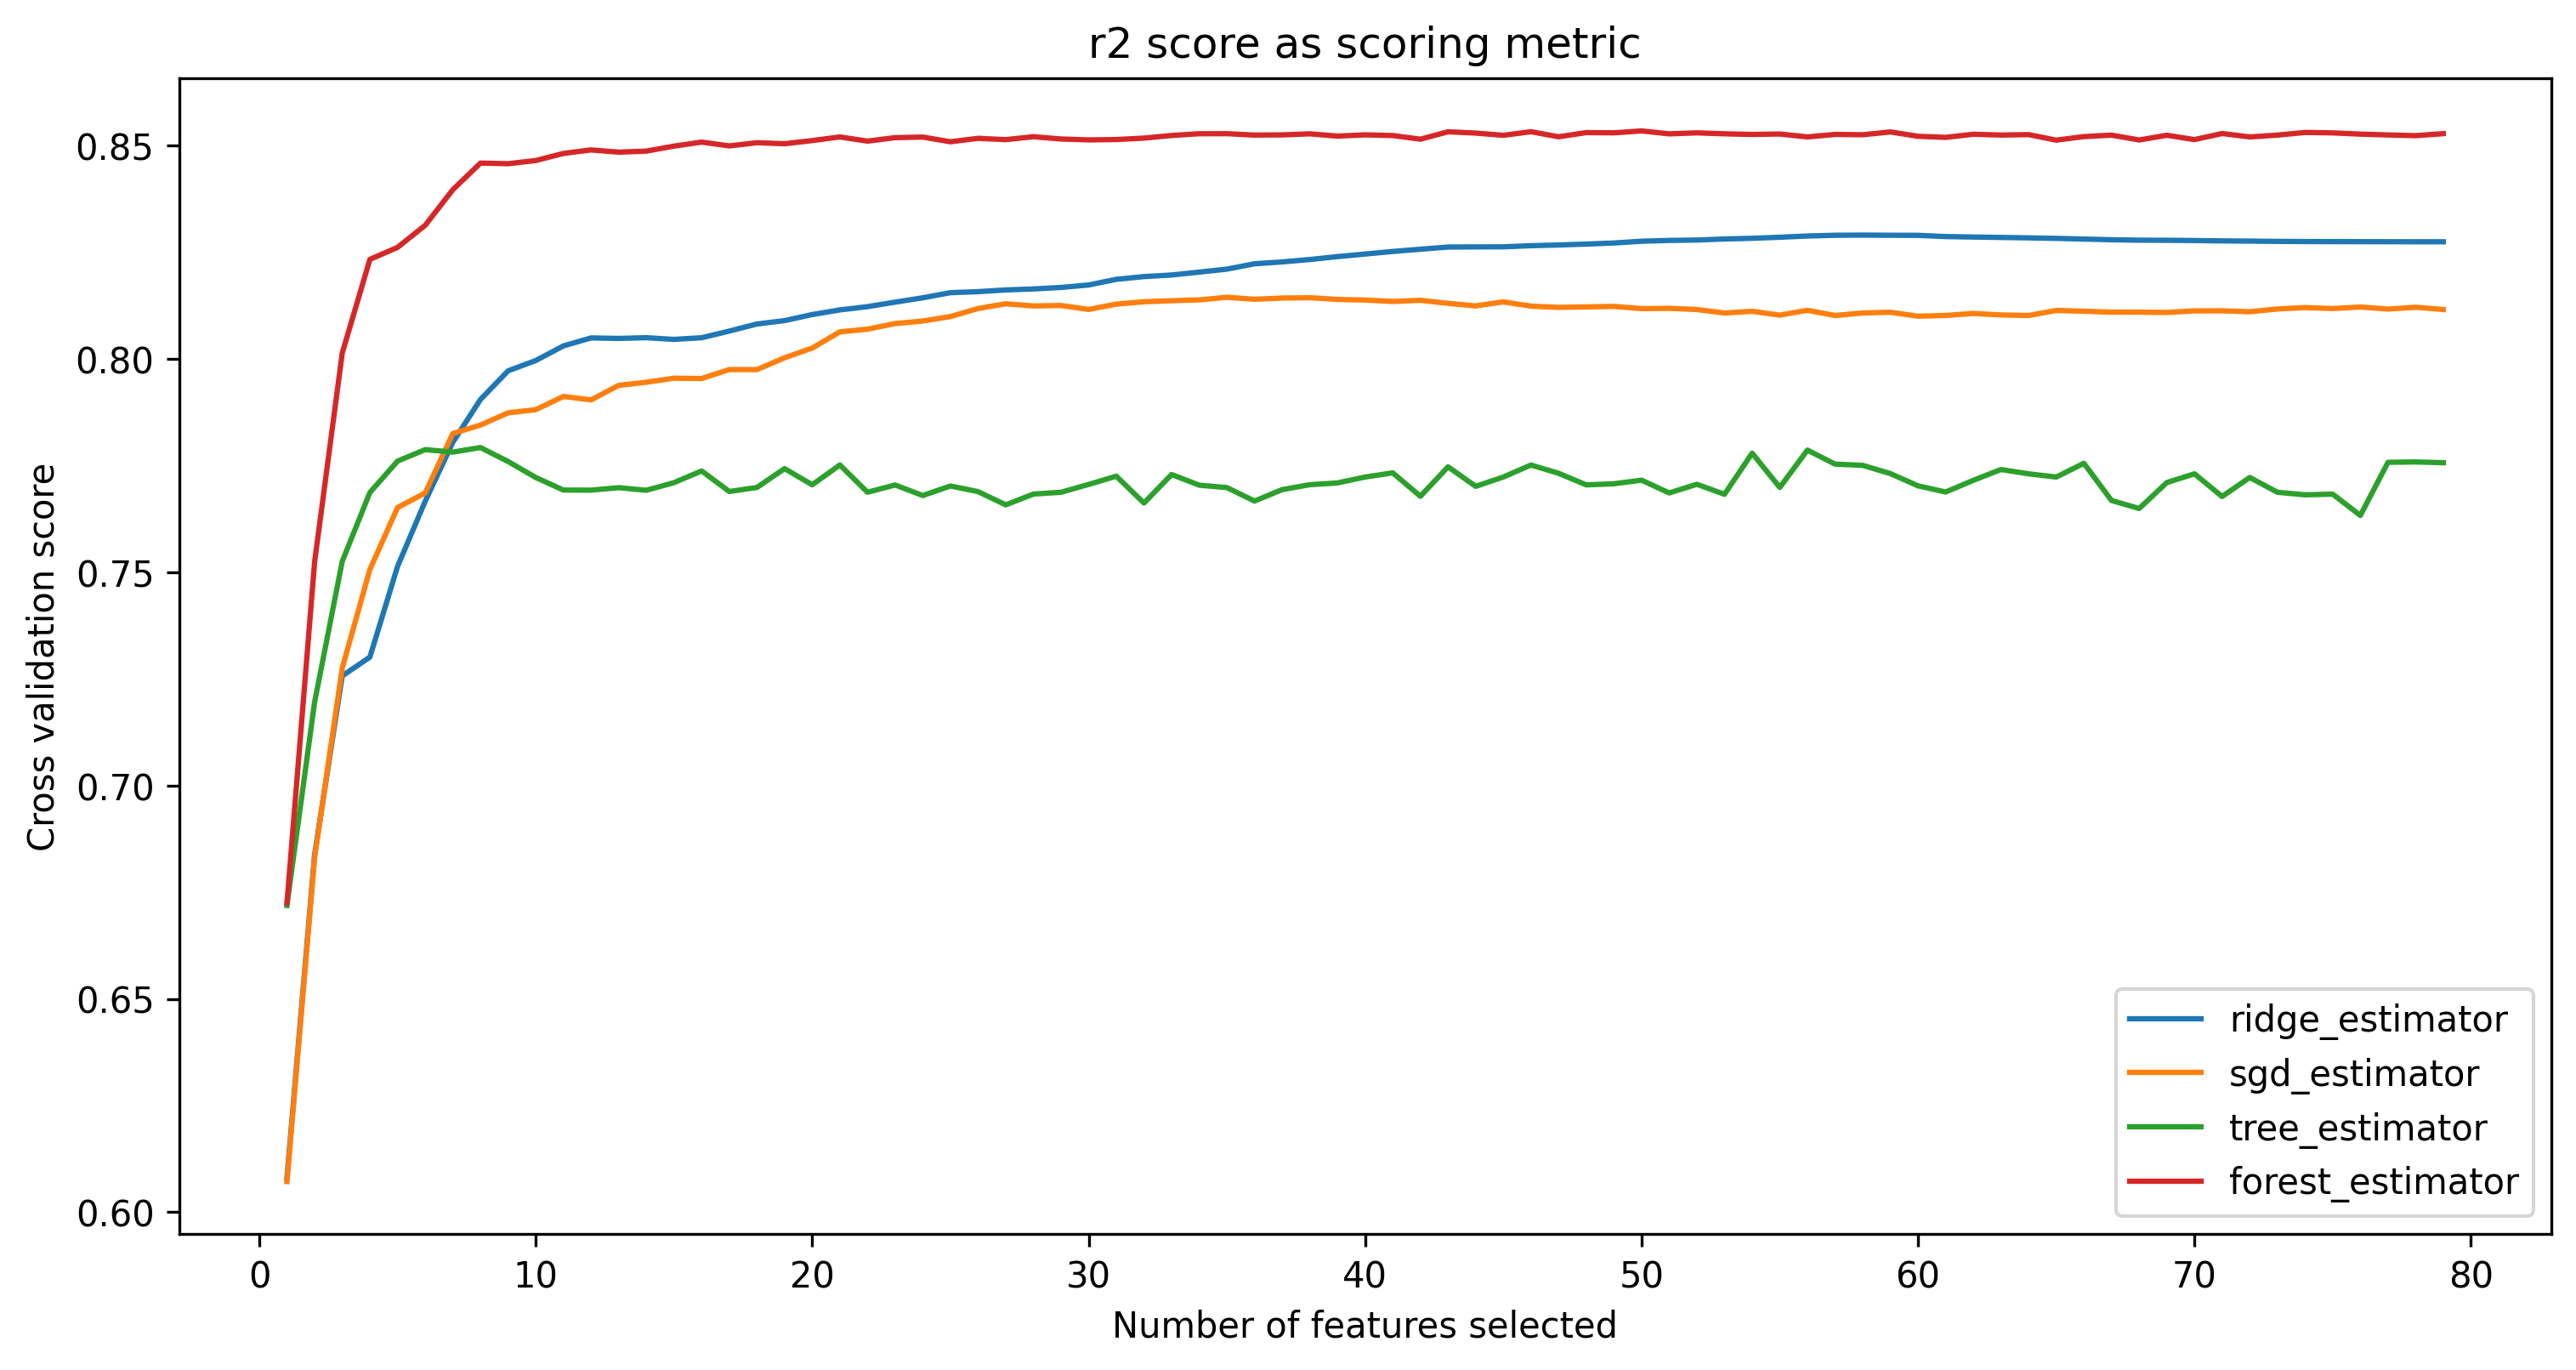

In [36]:
labels = ['ridge_estimator', 'sgd_estimator', 'tree_estimator', 'forest_estimator']

plt.figure(figsize=[12, 6], dpi=300)
plt.title('r2 score as scoring metric')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")

for i in range(0, 4):
    sns.lineplot(x=list(range(1, len(rfecv[i].cv_results_['mean_test_score']) + 1)),
                 y=rfecv[i].cv_results_['mean_test_score'],
                 label=labels[i])

plt.show()

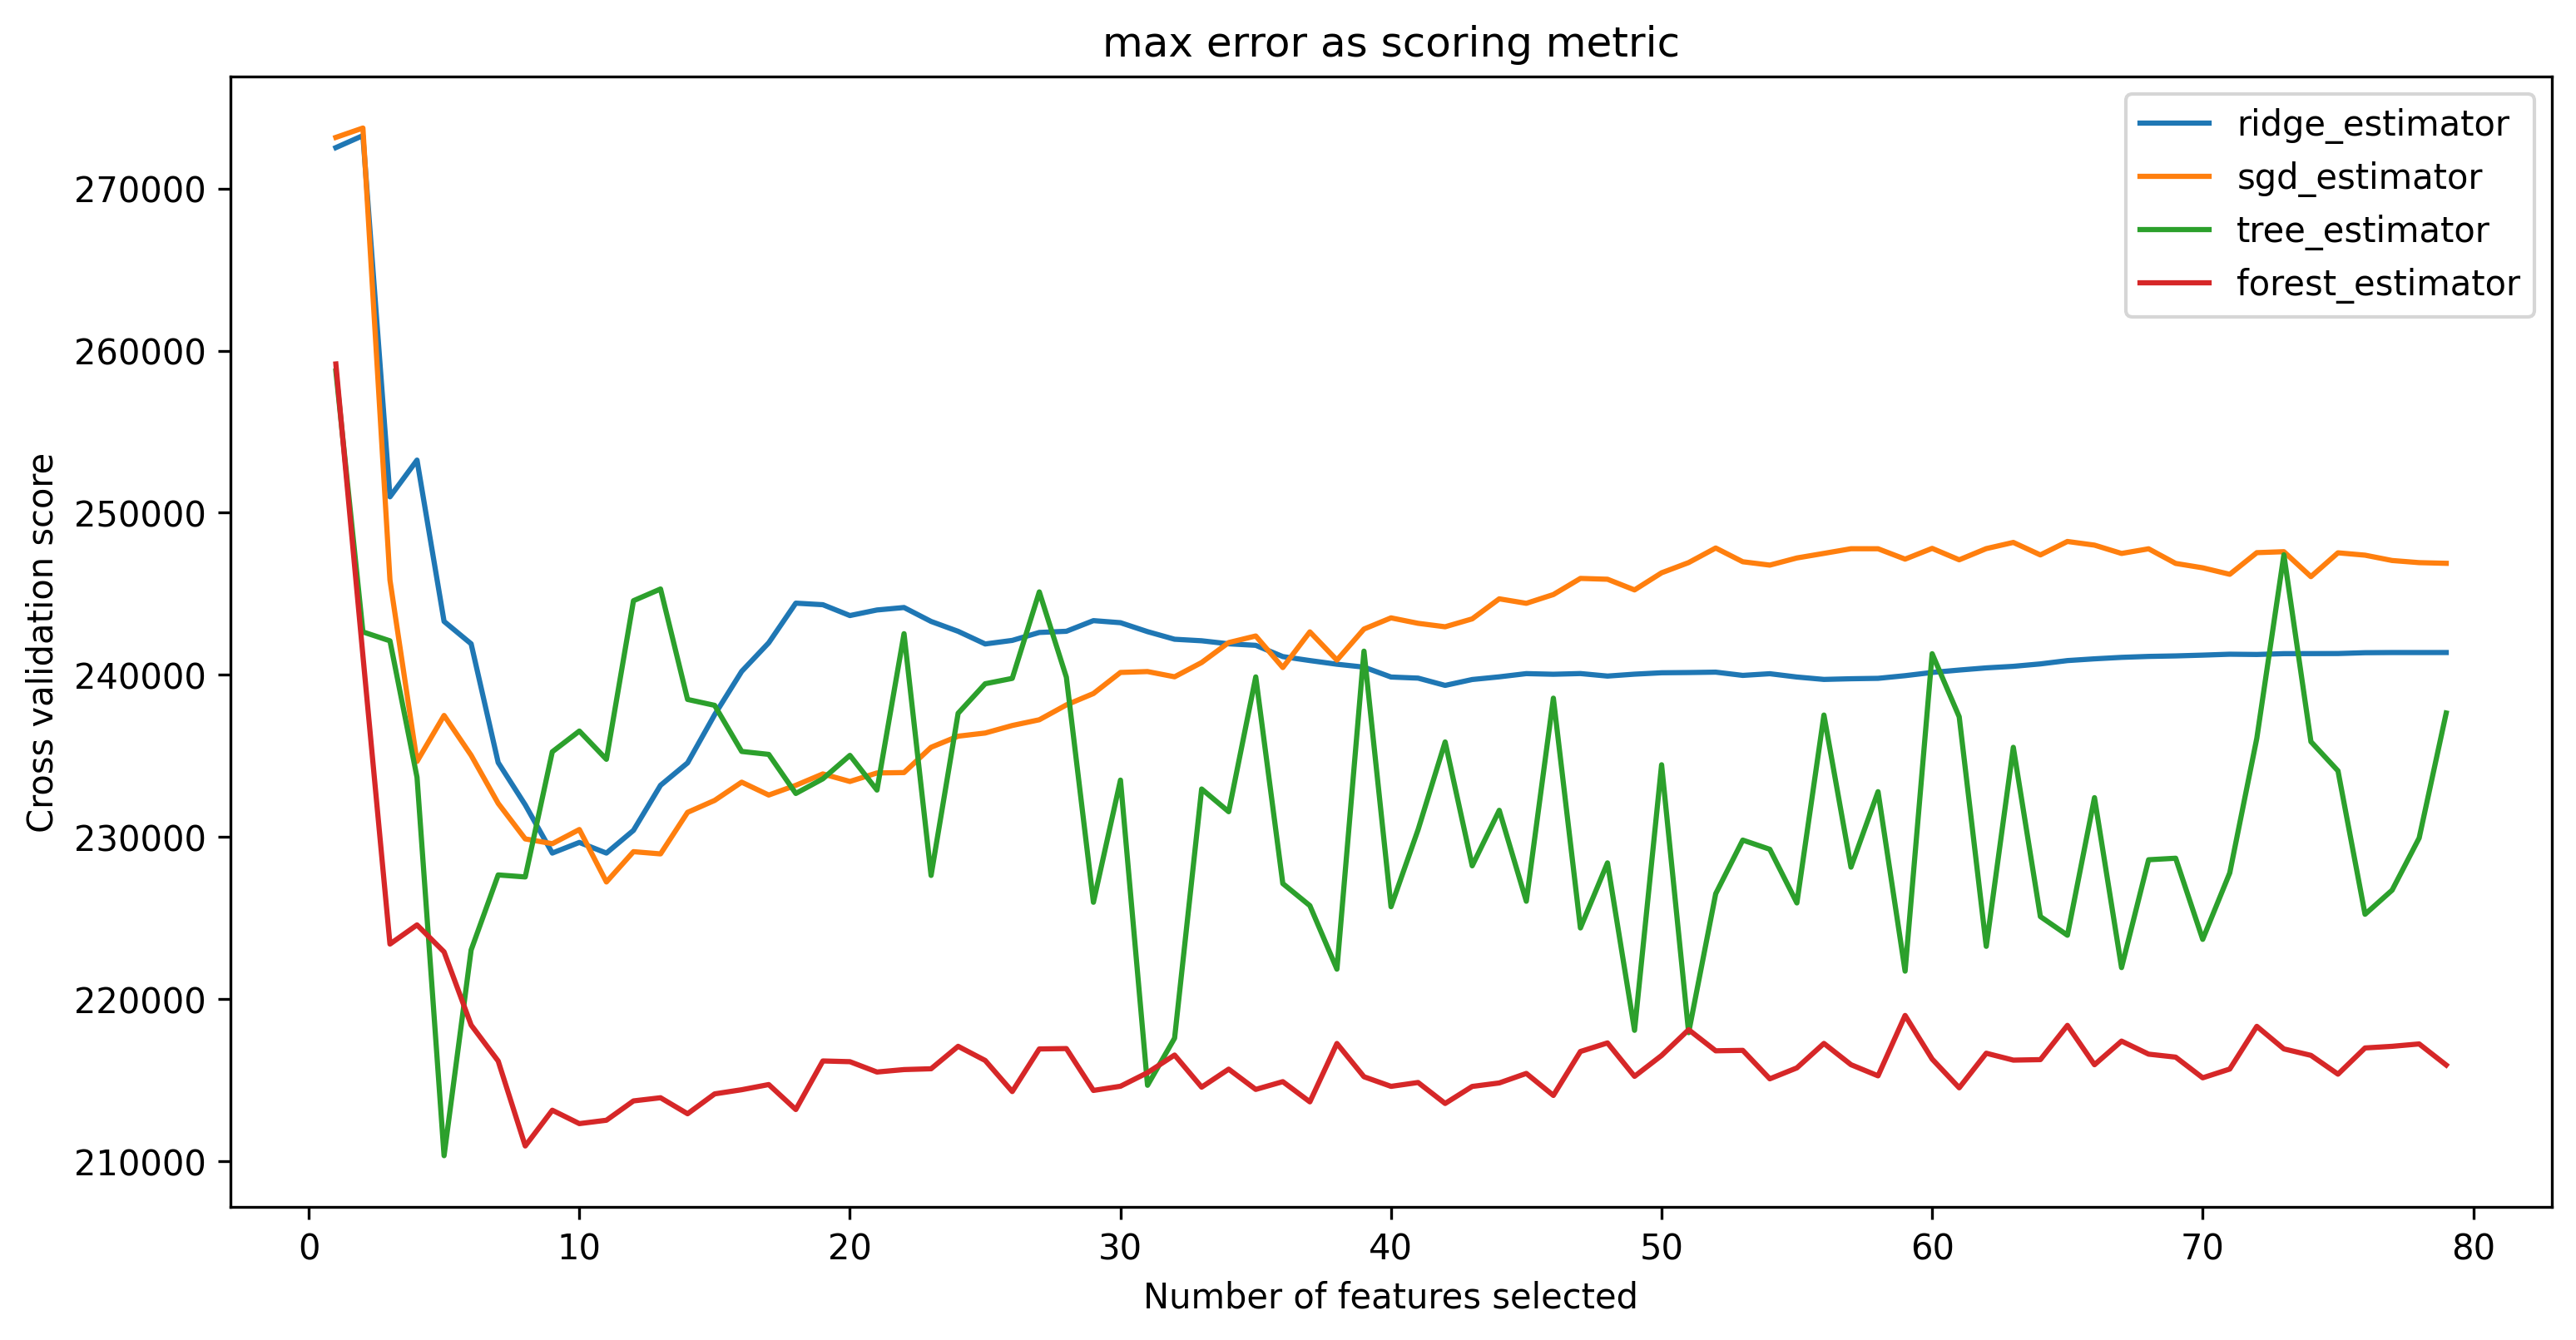

In [37]:
plt.figure(figsize=[12, 6], dpi=300)
plt.title('max error as scoring metric')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")

for i in range(4, 8):
    sns.lineplot(x=list(range(1, len(rfecv[i].cv_results_['mean_test_score']) + 1)),
                 y=rfecv[i].cv_results_['mean_test_score'],
                 label=labels[i - 4])

plt.show()

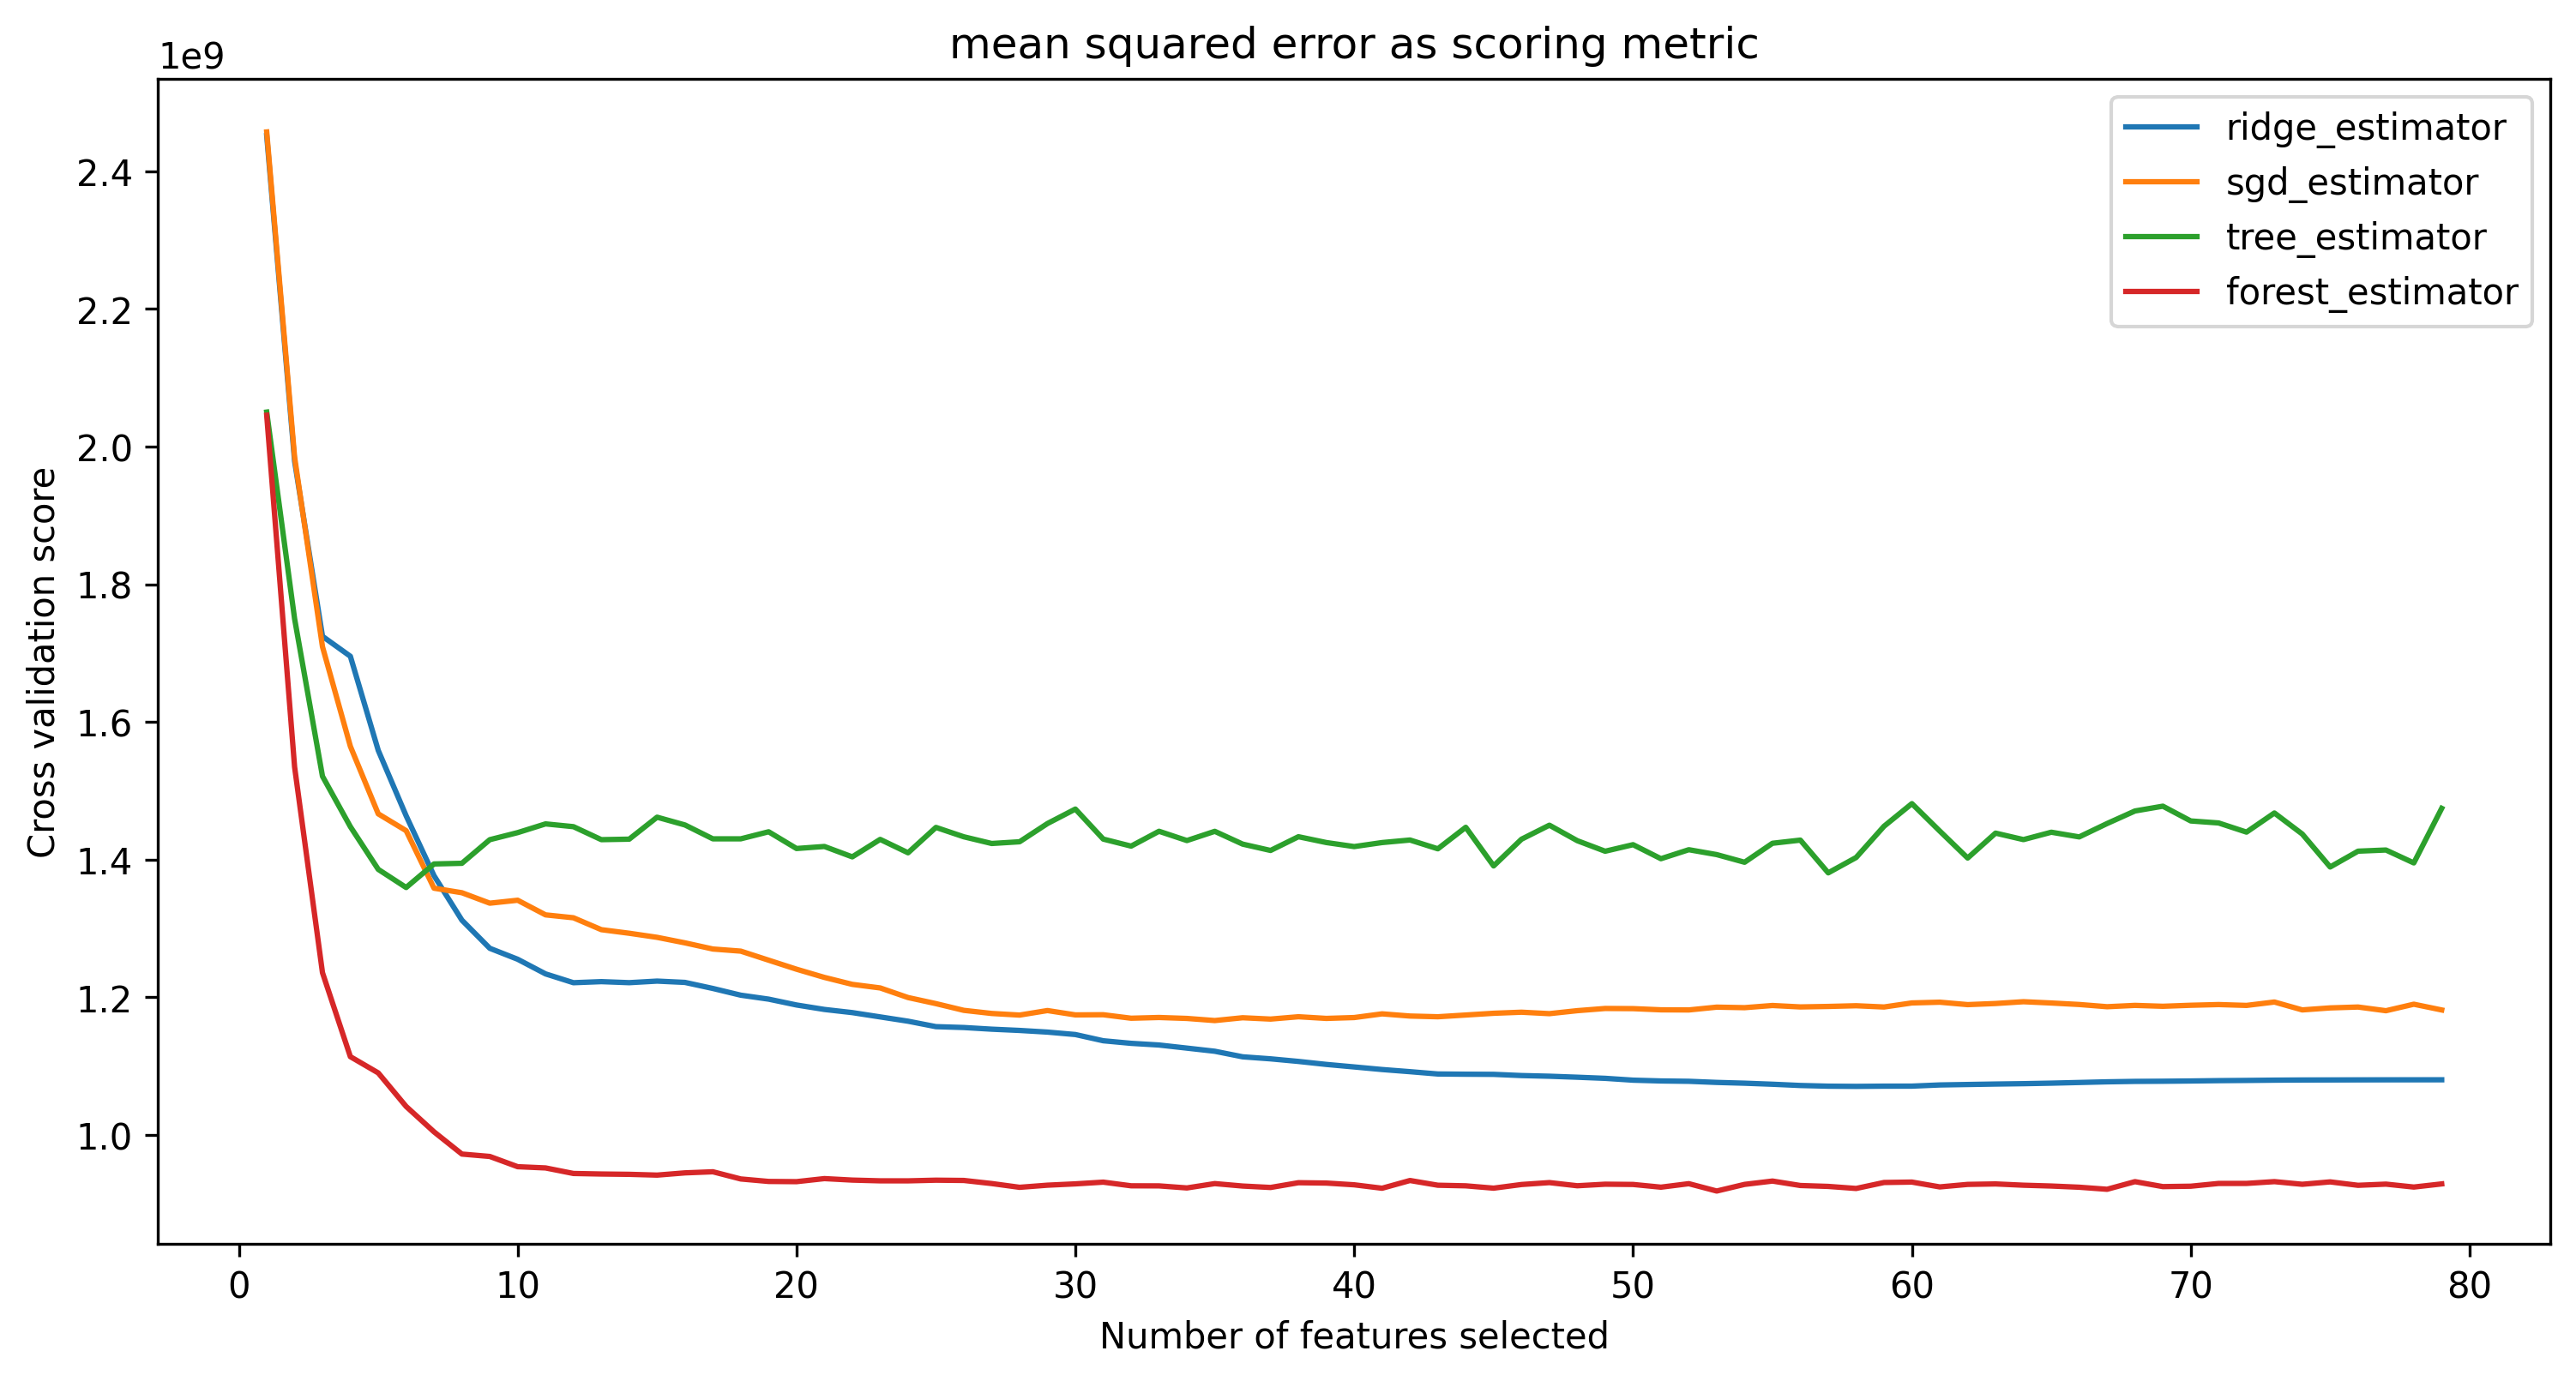

In [38]:
plt.figure(figsize=[12, 6], dpi=300)
plt.title('mean squared error as scoring metric')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")

for i in range(8, 12):
    sns.lineplot(x=list(range(1, len(rfecv[i].cv_results_['mean_test_score']) + 1)),
                 y=rfecv[i].cv_results_['mean_test_score'],
                 label=labels[i - 8])

plt.show()